In [19]:
'''
extraire une page d'un pdf

'''
import PyPDF2
import tabula
import pandas as pd
from pdf2image import convert_from_path
import cv2
import numpy as np
from PIL import Image, ImageOps
from PyPDF2 import PdfFileReader
import camelot
import matplotlib.pyplot as plt
import os
from wand.image import Image as wimage
import re

import tabula


num_page=1

DATAPATH = 'data/'
OUTPUTPATH = 'generated_output/'
INPUT_PDF='OneTablePage%d.pdf'%num_page
INPUT_JPG='OneTablePage%d.jpg'%num_page
OUTPUT_CSV='OneTablePage%d.csv'%num_page
OUTPUT_XLSX='OneTablePage%d.xlsx'%num_page
PDFfilename = "doc4.pdf" #filename of your PDF/directory where your PDF is stored


pfr = PyPDF2.PdfFileReader(open(PDFfilename, "rb")) #PdfFileReader object
pg4 = pfr.getPage(num_page) #extract pg 


(pdf_width,pdf_height)= (pfr.getPage(num_page).mediaBox[2],pfr.getPage(num_page).mediaBox[3])

writer = PyPDF2.PdfFileWriter() #create PdfFileWriter object
#add pages
writer.addPage(pg4)
NewPDFfilename = os.path.join(DATAPATH, INPUT_PDF) #filename of your PDF/directory where you want your new PDF to be
with open(NewPDFfilename, "wb") as outputStream:
    writer.write(outputStream) #write pages to new PDF


In [20]:
#pour convertir la page en jpg

import os
import tempfile
from pdf2image import convert_from_path


images_from_path = convert_from_path(PDFfilename, last_page=num_page+1, first_page =num_page+1)

for page in images_from_path:
    page.save(os.path.join(DATAPATH, INPUT_JPG), 'JPEG')

In [21]:
# -*- coding: utf-8 -*-

from __future__ import division

import cv2
import numpy as np


def adaptive_threshold(imagename, process_background=False, blocksize=15, c=-2):
    """Thresholds an image using OpenCV's adaptiveThreshold.
    Parameters
    ----------
    imagename : string
        Path to image file.
    process_background : bool, optional (default: False)
        Whether or not to process lines that are in background.
    blocksize : int, optional (default: 15)
        Size of a pixel neighborhood that is used to calculate a
        threshold value for the pixel: 3, 5, 7, and so on.
        For more information, refer `OpenCV's adaptiveThreshold <https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html#adaptivethreshold>`_.
    c : int, optional (default: -2)
        Constant subtracted from the mean or weighted mean.
        Normally, it is positive but may be zero or negative as well.
        For more information, refer `OpenCV's adaptiveThreshold <https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html#adaptivethreshold>`_.
    Returns
    -------
    img : object
        numpy.ndarray representing the original image.
    threshold : object
        numpy.ndarray representing the thresholded image.
    """
    img = cv2.imread(imagename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    if process_background:
        threshold = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY, blocksize, c)
    else:
        threshold = cv2.adaptiveThreshold(
            np.invert(gray), 255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blocksize, c)
    return img, threshold


def find_lines(threshold, regions=None, direction='horizontal',
               line_scale=15, iterations=0):
    """Finds horizontal and vertical lines by applying morphological
    transformations on an image.
    Parameters
    ----------
    threshold : object
        numpy.ndarray representing the thresholded image.
    regions : list, optional (default: None)
        List of page regions that may contain tables of the form x1,y1,x2,y2
        where (x1, y1) -> left-top and (x2, y2) -> right-bottom
        in image coordinate space.
    direction : string, optional (default: 'horizontal')
        Specifies whether to find vertical or horizontal lines.
    line_scale : int, optional (default: 15)
        Factor by which the page dimensions will be divided to get
        smallest length of lines that should be detected.
        The larger this value, smaller the detected lines. Making it
        too large will lead to text being detected as lines.
    iterations : int, optional (default: 0)
        Number of times for erosion/dilation is applied.
        For more information, refer `OpenCV's dilate <https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html#dilate>`_.
    Returns
    -------
    dmask : object
        numpy.ndarray representing pixels where vertical/horizontal
        lines lie.
    lines : list
        List of tuples representing vertical/horizontal lines with
        coordinates relative to a left-top origin in
        image coordinate space.
    """
    lines = []

    if direction == 'vertical':
        size = threshold.shape[0] // line_scale
        el = cv2.getStructuringElement(cv2.MORPH_RECT, (1, size))
    elif direction == 'horizontal':
        size = threshold.shape[1] // line_scale
        el = cv2.getStructuringElement(cv2.MORPH_RECT, (size, 1))
    elif direction is None:
        raise ValueError("Specify direction as either 'vertical' or"
                         " 'horizontal'")

    if regions is not None:
        region_mask = np.zeros(threshold.shape)
        for region in regions:
            x, y, w, h = region
            region_mask[y : y + h, x : x + w] = 1
        threshold = np.multiply(threshold, region_mask)

    threshold = cv2.erode(threshold, el)
    threshold = cv2.dilate(threshold, el)
    dmask = cv2.dilate(threshold, el, iterations=iterations)

    try:
        _, contours, _ = cv2.findContours(
            threshold.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    except ValueError:
        # for opencv backward compatibility
        contours, _ = cv2.findContours(
            threshold.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        x1, x2 = x, x + w
        y1, y2 = y, y + h
        if direction == 'vertical':
            lines.append(((x1 + x2) // 2, y2, (x1 + x2) // 2, y1))
        elif direction == 'horizontal':
            lines.append((x1, (y1 + y2) // 2, x2, (y1 + y2) // 2))

    return dmask, lines


def find_contours(vertical, horizontal):
    """Finds table boundaries using OpenCV's findContours.
    Parameters
    ----------
    vertical : object
        numpy.ndarray representing pixels where vertical lines lie.
    horizontal : object
        numpy.ndarray representing pixels where horizontal lines lie.
    Returns
    -------
    cont : list
        List of tuples representing table boundaries. Each tuple is of
        the form (x, y, w, h) where (x, y) -> left-top, w -> width and
        h -> height in image coordinate space.
    """
    mask = vertical + horizontal

    try:
        __, contours, __ = cv2.findContours(
            mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    except ValueError:
        # for opencv backward compatibility
        contours, __ = cv2.findContours(
            mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # sort in reverse based on contour area and use first 10 contours
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

    cont = []
    for c in contours:
        c_poly = cv2.approxPolyDP(c, 3, True)
        x, y, w, h = cv2.boundingRect(c_poly)
        cont.append((x, y, w, h))
    return cont


def find_joints(contours, vertical, horizontal):
    """Finds joints/intersections present inside each table boundary.
    Parameters
    ----------
    contours : list
        List of tuples representing table boundaries. Each tuple is of
        the form (x, y, w, h) where (x, y) -> left-top, w -> width and
        h -> height in image coordinate space.
    vertical : object
        numpy.ndarray representing pixels where vertical lines lie.
    horizontal : object
        numpy.ndarray representing pixels where horizontal lines lie.
    Returns
    -------
    tables : dict
        Dict with table boundaries as keys and list of intersections
        in that boundary as their value.
        Keys are of the form (x1, y1, x2, y2) where (x1, y1) -> lb
        and (x2, y2) -> rt in image coordinate space.
    """
    joints = np.multiply(vertical, horizontal)
    tables = {}
    for c in contours:
        x, y, w, h = c
        roi = joints[y : y + h, x : x + w]
        try:
            __, jc, __ = cv2.findContours(
                roi.astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
        except ValueError:
            # for opencv backward compatibility
            jc, __ = cv2.findContours(
                roi.astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
        if len(jc) <= 4:  # remove contours with less than 4 joints
            continue
        joint_coords = []
        for j in jc:
            jx, jy, jw, jh = cv2.boundingRect(j)
            c1, c2 = x + (2 * jx + jw) // 2, y + (2 * jy + jh) // 2
            joint_coords.append((c1, c2))
        tables[(x, y + h, x + w, y)] = joint_coords

    return tables

In [22]:
image ,threshold=adaptive_threshold(os.path.join(DATAPATH, INPUT_JPG), process_background=False, blocksize=15, c=-2)

In [23]:
vertical_mask, vertical_segments=find_lines(threshold, regions=None, direction='vertical',line_scale=15, iterations=0)
horizontal_mask, horizontal_segments=find_lines(threshold, regions=None, direction='horizontal',line_scale=15, iterations=0)

In [24]:
contours = find_contours(vertical_mask, horizontal_mask)


In [25]:
table_bbox = find_joints(contours, vertical_mask, horizontal_mask)


In [26]:
table_bbox 

{(40, 1446, 1616, 943): [(1613, 1444),
  (1505, 1444),
  (1401, 1444),
  (1321, 1444),
  (1250, 1444),
  (1179, 1444),
  (1107, 1444),
  (1036, 1444),
  (965, 1444),
  (894, 1444),
  (822, 1444),
  (749, 1444),
  (678, 1444),
  (607, 1444),
  (536, 1444),
  (465, 1444),
  (391, 1444),
  (99, 1444),
  (41, 1444),
  (1613, 1403),
  (1505, 1403),
  (1401, 1403),
  (1321, 1403),
  (1250, 1403),
  (1179, 1403),
  (1107, 1403),
  (1036, 1403),
  (965, 1403),
  (894, 1403),
  (822, 1403),
  (749, 1403),
  (678, 1403),
  (607, 1403),
  (536, 1403),
  (465, 1403),
  (391, 1403),
  (99, 1403),
  (1613, 1378),
  (1505, 1378),
  (1401, 1378),
  (1321, 1378),
  (1250, 1378),
  (1179, 1378),
  (1107, 1378),
  (1036, 1378),
  (965, 1378),
  (894, 1378),
  (822, 1378),
  (749, 1378),
  (678, 1378),
  (607, 1378),
  (536, 1378),
  (465, 1378),
  (391, 1378),
  (99, 1378),
  (1613, 1352),
  (1505, 1352),
  (1401, 1352),
  (1321, 1352),
  (1250, 1352),
  (1179, 1352),
  (1107, 1352),
  (1036, 1352),
  (9

In [27]:
import copy
def translate(x1, x2):
    """Translates x2 by x1.
    Parameters
    ----------
    x1 : float
    x2 : float
    Returns
    -------
    x2 : float
    """
    x2 += x1
    return x2


def scale(x, s):
    """Scales x by scaling factor s.
    Parameters
    ----------
    x : float
    s : float
    Returns
    -------
    x : float
    """
    x *= s
    return x

def scale_image(tables, v_segments, h_segments, factors):
    """Translates and scales image coordinate space to pdf
    coordinate space.
    Parameters
    ----------
    tables : dict
        Dict with table boundaries as keys and list of intersections
        in that boundary as value.
    v_segments : list
        List of vertical line segments.
    h_segments : list
        List of horizontal line segments.
    factors : tuple
        Tuple (scaling_factor_x, scaling_factor_y, img_y) where the
        first two elements are scaling factors and img_y is height of
        image.
    Returns
    -------
    tables_new : dict
    v_segments_new : dict
    h_segments_new : dict
    """
    scaling_factor_x, scaling_factor_y, img_y = factors
    tables_new = {}
    for k in tables.keys():
        x1, y1, x2, y2 = k
        x1 = scale(x1, scaling_factor_x)
        y1 = scale(abs(translate(-img_y, y1)), scaling_factor_y)
        x2 = scale(x2, scaling_factor_x)
        y2 = scale(abs(translate(-img_y, y2)), scaling_factor_y)
        j_x, j_y = zip(*tables[k])
        j_x = [scale(j, scaling_factor_x) for j in j_x]
        j_y = [scale(abs(translate(-img_y, j)), scaling_factor_y) for j in j_y]
        joints = zip(j_x, j_y)
        tables_new[(x1, y1, x2, y2)] = joints

    v_segments_new = []
    for v in v_segments:
        x1, x2 = scale(v[0], scaling_factor_x), scale(v[2], scaling_factor_x)
        y1, y2 = scale(abs(translate(-img_y, v[1])), scaling_factor_y), scale(
            abs(translate(-img_y, v[3])), scaling_factor_y)
        v_segments_new.append((x1, y1, x2, y2))

    h_segments_new = []
    for h in h_segments:
        x1, x2 = scale(h[0], scaling_factor_x), scale(h[2], scaling_factor_x)
        y1, y2 = scale(abs(translate(-img_y, h[1])), scaling_factor_y), scale(
            abs(translate(-img_y, h[3])), scaling_factor_y)
        h_segments_new.append((x1, y1, x2, y2))

    return tables_new, v_segments_new, h_segments_new



image_width =  image.shape[1]
image_height =  image.shape[0]
image_width_scaler = image_width / int(pdf_width)
image_height_scaler = image_height / int(pdf_height)
pdf_width_scaler =  pdf_width / int(image_width)
pdf_height_scaler =  pdf_height / int(image_height)
image_scalers = (image_width_scaler, image_height_scaler,  pdf_height)
pdf_scalers = (pdf_width_scaler, pdf_height_scaler, image_height)

table_bbox_unscaled = copy.deepcopy(table_bbox)
table_bbox, vertical_segments, horizontal_segments = scale_image(table_bbox, vertical_segments, horizontal_segments, pdf_scalers)


In [28]:
table_bbox_unscaled

{(40, 1446, 1616, 943): [(1613, 1444),
  (1505, 1444),
  (1401, 1444),
  (1321, 1444),
  (1250, 1444),
  (1179, 1444),
  (1107, 1444),
  (1036, 1444),
  (965, 1444),
  (894, 1444),
  (822, 1444),
  (749, 1444),
  (678, 1444),
  (607, 1444),
  (536, 1444),
  (465, 1444),
  (391, 1444),
  (99, 1444),
  (41, 1444),
  (1613, 1403),
  (1505, 1403),
  (1401, 1403),
  (1321, 1403),
  (1250, 1403),
  (1179, 1403),
  (1107, 1403),
  (1036, 1403),
  (965, 1403),
  (894, 1403),
  (822, 1403),
  (749, 1403),
  (678, 1403),
  (607, 1403),
  (536, 1403),
  (465, 1403),
  (391, 1403),
  (99, 1403),
  (1613, 1378),
  (1505, 1378),
  (1401, 1378),
  (1321, 1378),
  (1250, 1378),
  (1179, 1378),
  (1107, 1378),
  (1036, 1378),
  (965, 1378),
  (894, 1378),
  (822, 1378),
  (749, 1378),
  (678, 1378),
  (607, 1378),
  (536, 1378),
  (465, 1378),
  (391, 1378),
  (99, 1378),
  (1613, 1352),
  (1505, 1352),
  (1401, 1352),
  (1321, 1352),
  (1250, 1352),
  (1179, 1352),
  (1107, 1352),
  (1036, 1352),
  (9

In [29]:
table_bbox

{(Decimal('14.39709794437726723095525998'),
  Decimal('321.4341855493800769559640873'),
  Decimal('581.6427569528415961305925030'),
  Decimal('502.4883796494228302693458744')): <zip at 0x244b8831808>,
 (Decimal('14.39709794437726723095525998'),
  Decimal('106.5448140230867892261650278'),
  Decimal('579.8431197097944377267230955'),
  Decimal('288.3189055151774262505344164')): <zip at 0x244b88318c8>,
 (Decimal('14.39709794437726723095525998'),
  Decimal('535.6036596836254809747755452'),
  Decimal('582.7225392986698911729141475'),
  Decimal('670.9443693886276186404446345')): <zip at 0x244b8831e88>}

In [30]:
def extractMultipleTable(table_bbox):
    allTables=[]
    print("plusieurs tableau dans la page à detecter")
    i=0
    for key1, y in table_bbox.items():
        i+=1
        print('tableau %d'%i)
        x0=key1[0]
        y0=key1[3]
        x1=key1[2]
        y1=key1[1]
        tableRowTol2 = camelot.read_pdf(os.path.join(DATAPATH, INPUT_PDF),flavor='stream',row_tol=2,flag_size=True,table_areas=['%d,%d,%d,%d'%(x0,y0,x1,y1)]) #methode1
        tableRowTol4 = camelot.read_pdf(os.path.join(DATAPATH, INPUT_PDF),flavor='stream',row_tol=4,flag_size=True,table_areas=['%d,%d,%d,%d'%(x0,y0,x1,y1)]) #methode1


        if verifColumns(tableRowTol2[0].df)<verifColumns(tableRowTol4[0].df):    # dans ce cas df2 a plus de \n donc les colonnes n'ont pas été bien éclaté avec row_tol=4
            print("conserver row_tol =2")
            camelot.plot(tableRowTol2[0], kind='contour')
            plt.show()
            tableRowTol2[0].df.to_csv(os.path.join(OUTPUTPATH, 'tab%d_'%i+PDFfilename+OUTPUT_CSV), index=False)
            tableRowTol2[0].df.to_excel(os.path.join(OUTPUTPATH, 'tab%d_'%i+PDFfilename+OUTPUT_XLSX), index=False)
            finalDF=tableRowTol2[0].df
            allTables.append(finalDF)



        else:
            print("conserver row_tol=4")
            camelot.plot(tableRowTol4[0], kind='contour')
            plt.show()
            tableRowTol4[0].df.to_csv(os.path.join(OUTPUTPATH, 'tab%d_'%i+PDFfilename+OUTPUT_CSV), index=False)
            tableRowTol4[0].df.to_excel(os.path.join(OUTPUTPATH, 'tab%d_'%i+PDFfilename+OUTPUT_XLSX), index=False)
            finalDF=tableRowTol4[0].df
            allTables.append(finalDF)
            
    return allTables


def extractOneTable(table_bbox,table_bbox_unscaled):
    print("un seul tableau à detecter")
    for key1, y in table_bbox.items():
        x0=key1[0]
        y0=key1[3]
        x1=key1[2]
        y1=key1[1]

    for key2, y in table_bbox_unscaled.items():
        xx0=key2[0]
        yy0=key2[1]
        xx1=key2[2]
        yy1=key2[3]
    
    tables1 = camelot.read_pdf(os.path.join(DATAPATH, INPUT_PDF),flavor='stream',row_tol=4,flag_size=True,table_areas=['%d,%d,%d,%d'%(x0,y0,x1,y1)]) #methode1
    #tables2 = camelot.read_pdf(os.path.join(DATAPATH, INPUT_PDF),flavor='stream',row_tol=4,flag_size=True,table_areas=['%d,%d,%d,%d'%(xx0,yy0,xx1,yy1)]) #methode1

    
    #on verifie si on a besoin de corriger le decalage ou non

    '''mask1=tables1[0].df.mask(tables1[0].df.apply(lambda x: x.str.contains('[a-zA-Z]')),'')
    mask1.replace('', np.nan, inplace=True)
    mask1.dropna(axis=0, how='all',inplace=True,thresh=2)
    mask1.dropna(axis=1, how='all',inplace=True)
  
    mask2=tables2[0].df.mask(tables2[0].df.apply(lambda x: x.str.contains('[a-zA-Z]')),'')
    mask2.replace('', np.nan, inplace=True)
    mask2.dropna(axis=0, how='all',inplace=True,thresh=2)
    mask2.dropna(axis=1, how='all',inplace=True)
    
    
 
    
    if len(mask1)> len(mask2):
        print('conserver table1: apres correction de decalage')
        choix=2
        tableRowTol4=tables1
        
        
    else:
        print('conserver table2 :avant correction de decalage')
        choix=1
        tableRowTol4=tables2'''
    
    
    tableRowTol4=tables1

    

    '''if choix==1:
        tableRowTol2 = camelot.read_pdf(os.path.join(DATAPATH, INPUT_PDF),flavor='stream',row_tol=2,flag_size=True,table_areas=['%d, %d, %d, %d'%(xx0,yy0,xx1,yy1)]) #methode1
    else:
        tableRowTol2 = camelot.read_pdf(os.path.join(DATAPATH, INPUT_PDF),flavor='stream',row_tol=2,flag_size=True,table_areas=['%d, %d, %d, %d'%(x0,y0,x1,y1)]) #methode1

    '''
    tableRowTol2 = camelot.read_pdf(os.path.join(DATAPATH, INPUT_PDF),flavor='stream',row_tol=2,flag_size=True,table_areas=['%d, %d, %d, %d'%(x0,y0,x1,y1)]) #methode1


    
    if verifColumns(tableRowTol2[0].df)<verifColumns(tableRowTol4[0].df):    # dans ce cas df2 a plus de \n donc les colonnes n'ont pas été bien éclaté avec row_tol=4
        print("conserver row_tol =2")
        
        camelot.plot(tableRowTol2[0], kind='contour')
        plt.show()
        tableRowTol2[0].df.to_csv(os.path.join(OUTPUTPATH, OUTPUT_CSV), index=False)
        tableRowTol2[0].df.to_excel(os.path.join(OUTPUTPATH, OUTPUT_XLSX), index=False)
        finalDF=tableRowTol2[0].df


    else:
        print("conserver row_tol=4")
        camelot.plot(tableRowTol4[0], kind='contour')
        plt.show()
        tableRowTol4[0].df.to_csv(os.path.join(OUTPUTPATH, PDFfilename+'_'+OUTPUT_CSV), index=False)
        tableRowTol4[0].df.to_excel(os.path.join(OUTPUTPATH, PDFfilename+'_'+OUTPUT_XLSX), index=False)
        finalDF=tableRowTol4[0].df
    return finalDF

plusieurs tableau dans la page à detecter
tableau 1
conserver row_tol=4


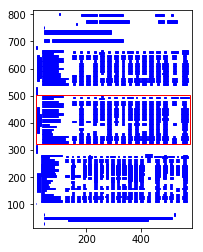

tableau 2
conserver row_tol=4


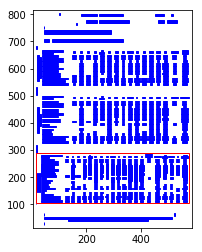

tableau 3
conserver row_tol=4


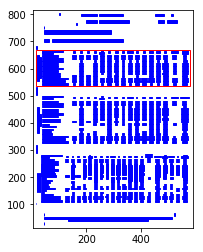

In [31]:
#pour verifier si on doit utiliser row_tol=2 ou row_tol=4
def verifColumns(dataframe):
    count=0
    for i in range(len(dataframe.columns)):
        for j in range(len(dataframe[i])):
            count+= dataframe[i][j].count("\n")
  
    
    return count

#pour verifier si on utilise le table_bbox_unscaled  ou table_bbox
def verifEmptyRows(dataframe):
    df=dataframe.replace('', np.nan)
    return df.isna().sum().sum()


def extractTables(table_bbox,table_bbox_unscaled):
    #pour savoir le nombre de tableau à detecter
    t = camelot.read_pdf(os.path.join(DATAPATH, INPUT_PDF),flavor='lattice',flag_size=True) #methode1

    if len(t)==0:
        print("pas de tableau dans la page")
        return (0,'')
    elif len(t)==1:
        finalDF=extractOneTable(table_bbox,table_bbox_unscaled)
        return (1,finalDF)


    else:
        listFinalDF=extractMultipleTable(table_bbox)
        return (len(t),listFinalDF)
    #return number of dataframes and the list of dataframes extracted




#traitement de tous les cas 0 , 1 ou plusieurs tableaux
(x , tables) = extractTables(table_bbox,table_bbox_unscaled)    


In [32]:
tables

[                           0             1                              2   \
 0                                                               DISCIPLINE   
 1                                                                  SUBAREA   
 2                                                     Included Contingency   
 3                                               Previous Rev.7 Contingency   
 4                                             Integrated Below Cellar Deck   
 5                                                   Integrated Cellar Deck   
 6                                                    Integrated Lower Deck   
 7                                             Integrated Intermediate Deck   
 8                                                    Integrated Upper Deck   
 9   INTEGRATED DECK PHASE 104  DRY IN PLACE        Integrated Weather Deck   
 10                                               Integrated Living Quarter   
 11                                                 

In [33]:
'''
Evaluation et extraction de titre de tableau

'''

def TransformFieldsInString(df):
    rows = []
    for i in range(len(df)):
        row=[]
        for col in df.columns:
            row.append(df[col][i])
        rows.append(row)
    A = np.array(rows)        
    data = pd.DataFrame(A)        
    data.columns = df.columns   
    return data 

def FindFirstNumber(df):
    test= False
    i = 0
    while (i<len(df) and test==False):
        h=0
        while(h<len(df.columns) and test==False):
            col = df.columns[h]
            if (VerifyNumber(str(df[col][i]))):
                test=True
            else :
                h = h+1
        if (h == len(df.columns) and test ==False):
            i=i+1
    return i   

def Evalute_Columns_Homogenity(df,colum_name,first_value_index):
    l = list(df[colum_name][first_value_index:len(df)])
    types =["string","int","float","None","BLANK"]
    (string,integer,real,NoneType,BLANK) = (0,0,0,0,0)
    for i in range(len(l)):

        if (str(regDataType(l[i])) == "STRING"):
            string = string+1
        elif (str(regDataType(l[i])) == "BLANK"):
            BLANK = BLANK+1
        elif (str(regDataType(l[i])) == "INT"):
            integer = integer+1
        elif (str(regDataType(l[i])) == "FLOAT"):
            real = real+1
        else:
            NoneType = NoneType+1
            
    string_pourcentage = string /len(l)
    integer_pourcentage = integer / len(l)
    real_pourcentage = real / len(l)
    NoneType_pourcentage = NoneType / len(l)
    Homogenity = max(string_pourcentage,integer_pourcentage,real_pourcentage,NoneType_pourcentage)
    return Homogenity

def regDataType(str):
    str=str.strip()
    if len(str) == 0: return 'BLANK'


    if re.match(r'([-+]\s*)?\d+\s?\d*$|([-+]\s*)?\d+\s?\d*\s?\D{1,2}$', str): 
        return 'INT'
    if re.match(r'([-+]\s*)?\d+\s?\d*[.,]?\d*$|([-+]\s*)?\d+\s?\d*[.,]?\d*\s?\D{1,2}$', str): 
        return 'FLOAT'

    return 'STRING' 
def Evaluate_Columns_Concatenation(df,column,first_value):
    l = list(df[column][first_value:len(df)])
    s = 0
    for i in range(len(l)):
        if ('\n' in l[i]  or '\s' in l[i]):
            s = s + 1
    NonConcatenation = (1 -s/len(l))
    return  NonConcatenation

def VerifyNumber(string):
    if regDataType(string)=='INT'or regDataType(string)=='FLOAT':
        return True
    return False
        
def Evaluation(df,k):

    GlobalHomogenity = sum(Evalute_Columns_Homogenity(df,colum_name,k) for colum_name in df.columns)/len(df.columns)
    GlobalNonConcatenation = sum(Evaluate_Columns_Concatenation(df,colum_name,k) for colum_name in df.columns)/len(df.columns)    
    
    return (GlobalHomogenity,GlobalNonConcatenation)

def getHeaderTable(df,k):
    rows=[]
    for i in range(0,k):
        row=[]
        for j in range(len(df.columns)):
            row.append(df[j][i])
          
        rows.append(row)
    tab = np.array(rows)        
    df1 = pd.DataFrame(tab)        
    
    if len(df1)==1:
        cols=rows
    else:
        cols=[]
        for i in range(len(df1.columns)):
            nameCol=''
            for j in range (len(df1)):
                
                nameCol= nameCol + ' ' + df1[i][j]
            cols.append(nameCol)
    return cols


def emptyCellsPourcentage(df):
    dfNan=df.replace('', np.nan)
    pourcentage_empty= dfNan.isnull().sum().sum()/(len(dfNan)*len(dfNan.columns))
    return pourcentage_empty


if x==1:
    tablesStream = camelot.read_pdf(os.path.join(DATAPATH, INPUT_PDF),flavor='stream',row_tol=4,flag_size=True) 

    pourcentage_empty1= emptyCellsPourcentage(tables)
    pourcentage_empty2= emptyCellsPourcentage(tablesStream[0].df)

    print("empty spaces represents %f  of the dataframe"%pourcentage_empty1)
    print("empty spaces represents %f  of the dataframe using STREAM parameter "%pourcentage_empty2)

    if pourcentage_empty1>= 0.3 and pourcentage_empty2<pourcentage_empty1:
        print("we try with stream : detection automatique")
        final0=tablesStream[0].df
    else:
        final0=tables

    

elif x>1:
    final0=[]
    for i in range(x):
        tablesStream = camelot.read_pdf(os.path.join(DATAPATH, INPUT_PDF),flavor='stream',row_tol=4,flag_size=True) 

        pourcentage_empty1= emptyCellsPourcentage(tables[i])
        pourcentage_empty2= emptyCellsPourcentage(tablesStream[0].df)

        print("empty spaces represents %f  of the dataframe"%pourcentage_empty1)
        print("empty spaces represents %f  of the dataframe using STREAM parameter "%pourcentage_empty2)

        if pourcentage_empty1>= 0.3 and pourcentage_empty2<pourcentage_empty1:
            print("we try with stream : detection automatique")
            final0.append(tablesStream[0].df)
        else:
            final0.append(tables[i])
            



empty spaces represents 0.279778  of the dataframe
empty spaces represents 0.174603  of the dataframe using STREAM parameter 
empty spaces represents 0.271825  of the dataframe
empty spaces represents 0.174603  of the dataframe using STREAM parameter 
empty spaces represents 0.214286  of the dataframe
empty spaces represents 0.174603  of the dataframe using STREAM parameter 


In [34]:
final0

[                           0             1                              2   \
 0                                                               DISCIPLINE   
 1                                                                  SUBAREA   
 2                                                     Included Contingency   
 3                                               Previous Rev.7 Contingency   
 4                                             Integrated Below Cellar Deck   
 5                                                   Integrated Cellar Deck   
 6                                                    Integrated Lower Deck   
 7                                             Integrated Intermediate Deck   
 8                                                    Integrated Upper Deck   
 9   INTEGRATED DECK PHASE 104  DRY IN PLACE        Integrated Weather Deck   
 10                                               Integrated Living Quarter   
 11                                                 

In [36]:
finalDataframes=[]
if x ==1:
    df0=TransformFieldsInString(final0)
    k = FindFirstNumber(df0)
    (e1,e2)=Evaluation(df0,k)
    print("evaluation du table %d,%d"%(e1,e2))

    header =getHeaderTable(final0,k)
    df = final0.iloc[k:]
    df.columns = header
    finalDataframes.append(df)
elif x>1:
    for i in range(x):
        df0=TransformFieldsInString(final0[i])

        k = FindFirstNumber(df0)
        print('**')
        (e1,e2)=Evaluation(df0,k)
        print("evaluation pour table %d = %d,%d"%(i,e1,e2))
        header =getHeaderTable(final0[i],k)
        df = final0[i].iloc[k:]
        df.columns = header
        finalDataframes.append(df)

    
for i in range(len(finalDataframes)):
    finalDataframes[i]
        

**
evaluation pour table 0 = 0,1
**
evaluation pour table 1 = 0,0
**
evaluation pour table 2 = 0,1


In [37]:
finalDataframes[0]

,,,DISCIPLINE SUBAREA,AR,EL,HV,IN,IN Valves,ME,PFP,SA,PA (ST),PI,ST I,ST II,ST III,ST,T & I Aids,TOTAL DRY
2,,,Included Contingency,6.8%,5.2%,6.0%,5.2%,5.0%,4.3%,5.0%,5.4%,5.0%,3.3%,3.1%,3.5%,5.6%,3.4%,20.0%,3.7%
3,,,Previous Rev.7 Contingency,6.9%,5.1%,5.0%,5.2%,5.0%,4.3%,5.0%,5.7%,5.0%,3.3%,3.1%,3.8%,5.8%,3.6%,10.0%,3.7%
4,,,Integrated Below Cellar Deck,,1 te,,1 te,13 te,13 te,2 te,0 te,2 te,12 te,20 te,16 te,7 te,43 te,,86 te
5,,,Integrated Cellar Deck,,134 te,,35 te,32 te,611 te,48 te,4 te,47 te,189 te,708 te,583 te,41 te,1 332 te,,2 431 te
6,,,Integrated Lower Deck,,89 te,,32 te,73 te,288 te,29 te,3 te,19 te,294 te,645 te,532 te,30 te,1 207 te,,2 035 te
7,,,Integrated Intermediate Deck,,96 te,,29 te,15 te,451 te,22 te,4 te,17 te,240 te,673 te,521 te,21 te,1 215 te,,2 090 te
8,,,Integrated Upper Deck,,94 te,,32 te,16 te,262 te,31 te,4 te,12 te,252 te,454 te,329 te,49 te,832 te,,1 534 te
9,INTEGRATED DECK PHASE 104,DRY IN PLACE,Integrated Weather Deck,,55 te,,18 te,14 te,987 te,7 te,3 te,18 te,260 te,876 te,487 te,61 te,1 424 te,,2 786 te
10,,,Integrated Living Quarter,267 te,235 te,101 te,70 te,,284 te,22 te,2 te,,5 te,,141 te,40 te,182 te,,1 167 te
11,,,Top Deck,,14 te,,6 te,12 te,74 te,3 te,2 te,5 te,144 te,168 te,159 te,5 te,332 te,7 te,600 te


In [38]:
header

['  ',
 '  ',
 ' DISCIPLINE SUBAREA',
 ' AR ',
 ' EL ',
 ' HV ',
 ' IN ',
 ' IN Valves',
 ' ME ',
 ' PFP ',
 ' SA ',
 ' PA (ST) ',
 ' PI ',
 ' ST I ',
 ' ST II ',
 ' ST III ',
 ' ST ',
 ' T & I Aids ',
 ' TOTAL LIFTING']